In [1]:
import sys, os
sys.path.insert(0, '..')

In [2]:
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx
from torch.utils.data import DataLoader
import torch


import graph_embeddings
from models.crosswalk import Crosswalk

from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings("ignore")

Using GPU: cuda:0



Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-09-05 21:15:01.474043: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-09-05 21:15:01.500986: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304000000 Hz
2022-09-05 21:15:01.502639: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55594ba92bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-05 21:15:01.502661: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-05 21:15:01

In [3]:
window_length = 5
num_walks = 10
dim = 128
walk_length = 80
NUM_WORKERS = 4

# POLBOOKS DATASET

In [4]:
DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)
models, embs = {}, {}

In [5]:
from residual2vec.word2vec import Word2Vec
k = "degree-unbiased"
model = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    walk_length=walk_length
).fit(A)

adjusted_num_walks = np.ceil(
        num_walks
        * np.maximum(
            1,
            model.batch_size
            * model.miniters
            / (model.n_nodes * num_walks * walk_length),
        )
    ).astype(int)
d = rv.TripletSimpleDataset(
        adjmat=model.adjmat,
        group_ids=group_ids,
        num_walks=adjusted_num_walks,
        window_length=model.window_length,
        noise_sampler=model.sampler,
        padding_id=model.n_nodes,
        walk_length=model.walk_length,
        p=model.p,
        q=model.q,
        buffer_size=model.buffer_size,
        context_window_type=model.context_window_type,
    )
dataloader = DataLoader(
        d,
        batch_size=model.batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
models[k] = model
m = Word2Vec(vocab_size=A.shape[0] + 1, embedding_size=dim, padding_idx=A.shape[0])
embs[k] = models[k].transform(model=m, dataloader=dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 498.77it/s, loss=1.2]


In [6]:
k = "group-unbiased"
model = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    walk_length=walk_length,
).fit(A)
adjusted_num_walks = np.ceil(
        num_walks
        * np.maximum(
            1,
            model.batch_size
            * model.miniters
            / (model.n_nodes * num_walks * walk_length),
        )
    ).astype(int)
d = rv.TripletSimpleDataset(
        adjmat=model.adjmat,
        group_ids=group_ids,
        num_walks=adjusted_num_walks,
        window_length=model.window_length,
        noise_sampler=model.sampler,
        padding_id=model.n_nodes,
        walk_length=model.walk_length,
        p=model.p,
        q=model.q,
        buffer_size=model.buffer_size,
        context_window_type=model.context_window_type,
    )
dataloader = DataLoader(
        d,
        batch_size=model.batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
models[k] = model
m = Word2Vec(vocab_size=A.shape[0] + 1, embedding_size=dim, padding_idx=A.shape[0])
embs[k] = models[k].transform(model=m, dataloader=dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 518.99it/s, loss=1.17]


In [7]:
embs["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks).fit(A).transform(dim=dim)
embs["fairwalk-group"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
).fit(A).transform(dim=dim)
embs['GCN'] = graph_embeddings.GCN().fit(A).transform(dim=dim)
embs["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2).fit(A).transform(dim=dim)
embs["graphsage"] = graph_embeddings.GraphSage().fit(A).transform(dim=dim)
embs["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2).fit(A).transform(dim=dim)
embs["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256]).fit(A).transform(dim=dim)
embs["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2).fit(A).transform(dim=dim)

embs['crosswalk'] = Crosswalk(group_membership=group_ids, window_length=window_length, num_walks=num_walks).fit(A).transform(dim=dim)

Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VE

1/1 [==============================] - 0s 61ms/step - loss: 0.0067 - val_loss: 0.0120
Epoch 51/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0074 - val_loss: 0.0119
Epoch 52/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0068 - val_loss: 0.0118
Epoch 53/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0067 - val_loss: 0.0117
Epoch 54/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0066 - val_loss: 0.0117
Epoch 55/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0069 - val_loss: 0.0118
Epoch 56/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0065 - val_loss: 0.0118
Epoch 57/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0066 - val_loss: 0.0118
Epoch 58/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0068 - val_loss: 0.0119
Epoch 59/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0064 - val_loss: 0.0121
Epoch 60/200
1/1 [=====

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/200
1/1 [==============================] - 1s 764ms/step - loss: 0.0097 - val_loss: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 3/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 4/200
1/1 [==============================] - 0s 99ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 5/200
1/1 [==============================] - 0s 92ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 6/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 7/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 8/200


Epoch 78/200
1/1 [==============================] - 0s 86ms/step - loss: 0.0060 - val_loss: 0.0129
Epoch 79/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0061 - val_loss: 0.0128
Epoch 80/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0058 - val_loss: 0.0127
Epoch 81/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0054 - val_loss: 0.0127
Epoch 82/200
1/1 [==============================] - 0s 102ms/step - loss: 0.0058 - val_loss: 0.0126
Epoch 83/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0057 - val_loss: 0.0126
Epoch 84/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0058 - val_loss: 0.0127
Epoch 85/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0059 - val_loss: 0.0129
Epoch 86/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0054 - val_loss: 0.0132
Epoch 87/200
1/1 [==============================] - 0s 39ms/step - loss: 0.0059 - val_loss: 0.0132
Epoch 88/

  ...
    to  
  ['...']
Train for 1 steps
Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.7140 - binary_accuracy: 0.5000
Epoch 2/5


2022-09-05 21:15:25.899030: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 581ms/step - loss: 0.7053 - binary_accuracy: 0.5000
Epoch 3/5


2022-09-05 21:15:26.539553: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 560ms/step - loss: 0.6670 - binary_accuracy: 0.5190
Epoch 4/5


2022-09-05 21:15:27.198700: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 811ms/step - loss: 0.6328 - binary_accuracy: 0.6714
Epoch 5/5


2022-09-05 21:15:27.897599: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 704ms/step - loss: 0.6261 - binary_accuracy: 0.6714


2022-09-05 21:15:28.585060: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 238ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


2022-09-05 21:15:29.180019: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

2022-09-05 21:15:31.239367: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 640ms/step - loss: 0.7160 - binary_accuracy: 0.5000
Epoch 3/5


2022-09-05 21:15:31.915894: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 663ms/step - loss: 0.6805 - binary_accuracy: 0.5000
Epoch 4/5


2022-09-05 21:15:32.598208: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 703ms/step - loss: 0.6526 - binary_accuracy: 0.6000
Epoch 5/5


2022-09-05 21:15:33.297844: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 689ms/step - loss: 0.6239 - binary_accuracy: 0.6952


2022-09-05 21:15:34.013286: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 271ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


2022-09-05 21:15:34.605465: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

Epoch 62/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 63/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 64/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 65/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 66/200
1/1 [==============================] - 0s 103ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 67/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 68/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 69/200
1/1 [==============================] - 0s 89ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 70/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 71/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 72/

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/200
1/1 [==============================] - 2s 2s/step - lo

Epoch 66/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 67/200
1/1 [==============================] - 0s 100ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 68/200
1/1 [==============================] - 0s 95ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 69/200
1/1 [==============================] - 0s 115ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 70/200
1/1 [==============================] - 0s 130ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 71/200
1/1 [==============================] - 0s 101ms/step - loss: 0.0097 - val_loss: 0.0100
Epoch 72/200
1/1 [==============================] - 0s 118ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 73/200
1/1 [==============================] - 0s 118ms/step - loss: 0.0092 - val_loss: 0.0100
Epoch 74/200
1/1 [==============================] - 0s 102ms/step - loss: 0.0090 - val_loss: 0.0100
Epoch 75/200
1/1 [==============================] - 0s 115ms/step - loss: 0.0087 - val_loss: 0.0100
Ep

assigning final weights: 100%|████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 139323.61it/s]


In [8]:
for k, v in embs.items():
    print(k, v.shape)

degree-unbiased (105, 128)
group-unbiased (105, 128)
fairwalk (105, 128)
fairwalk-group (105, 128)
GCN (105, 128)
gcn-doubleK (105, 128)
graphsage (105, 128)
graphsage-doubleK (105, 128)
gat (105, 128)
gat-doubleK (105, 128)
crosswalk (75, 128)


In [9]:
def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)

In [10]:

rgraphs = {}
for k, emb in embs.items():

    n_edges = int(A.sum() / 2)
    n_nodes = A.shape[0]
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [11]:
from utils.score import statistical_parity
scores = {}
for k, graph in rgraphs.items():
    # we will have to change group ids as well.
    edges = list(nx.to_edgelist(graph))
    edges = pd.DataFrame({
        'source': [i[0] for i in edges],
        'target': [i[1] for i in edges]
    })
    scores[k] = statistical_parity(edges, group_ids)
    print("class score: ", k, scores[k])

[-0.46153846  0.44230768  0.22115384]
class score:  degree-unbiased 0.375
[-0.20192307  0.46153846 -0.5192308 ]
class score:  group-unbiased 0.39423075
[-0.45192307  0.44230768 -0.75961536]
class score:  fairwalk 0.551282
[-0.43269232  0.44230768 -0.7307692 ]
class score:  fairwalk-group 0.5352564
[-0.29807693  0.43269232  0.17307693]
class score:  GCN 0.30128208
[-0.34615386  0.46153846  0.33653846]
class score:  gcn-doubleK 0.38141024
[-0.3846154   0.46153846 -0.5480769 ]
class score:  graphsage 0.4647436
[-0.48076922  0.45192307  0.3653846 ]
class score:  graphsage-doubleK 0.4326923
[-0.52884614  0.44230768 -0.7980769 ]
class score:  gat 0.5897436
[-0.47115386  0.42307693 -0.72115386]
class score:  gat-doubleK 0.5384615
[-0.35576922  0.47115386  0.44230768]
class score:  crosswalk 0.4230769


[Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK'),
 Text(0,0,'crosswalk')]

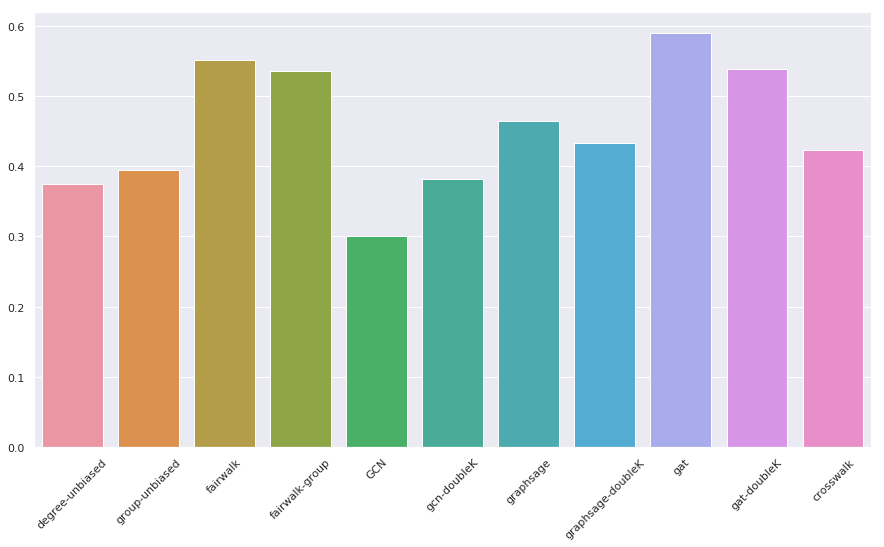

In [12]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [13]:
# from utils.score import opportunity_difference
# scores = {}
# for k, graph in rgraphs.items():
#     # we will have to change group ids as well.
#     edges = list(nx.to_edgelist(graph))
#     edges = pd.DataFrame({
#         'source': [i[0] for i in edges],
#         'target': [i[1] for i in edges]
#     })
#     scores[k] = opportunity_difference(edges, group_ids)
#     print("class score: ", k, scores[k])

In [14]:
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)